In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Mobilenet - Signlanguage
(https://arxiv.org/pdf/1704.04861.pdf)  

Much smaller, lightweight and faster 
(Good for mobile devices)  
VGG16 553MB  138,000,000 Parameters  
MobileNet 17MB 4,200,000 Parameters

Trade-off in accuracy (but quite small)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Fine-tune MobileNet on Sign Language

dataset: (https://github.com/ardamavi/Sign-Language-Digits-Dataset)

10 Classes:  

    - class 0 : 205  
    - class 1 : 206  
    - class 2 : 206  
    - class 3 : 206  
    - class 4 : 207  
    - class 5 : 207  
    - class 6 : 207  
    - class 7 : 206  
    - class 8 : 208  
    - class 9 : 204 
    


In [23]:
# Organize data into Train, valid, test dir
os.chdir('../data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../../Keras')

In [24]:
train_path = '../data/Sign-Language-Digits-Dataset/train'
valid_path = '../data/Sign-Language-Digits-Dataset/valid'
test_path = '../data/Sign-Language-Digits-Dataset/test'


In [25]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,
                                                                                                                            target_size=(224,224),
                                                                                                                            batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path,
                                                                                                                            target_size=(224,224),
                                                                                                                            batch_size=10)
# Shuffle = False so assessing results can be consistent
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,
                                                                                                                            target_size=(224,224),
                                                                                                                            batch_size=10,
                                                                                                                            shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Modify Model

In [27]:
def plotImage(images_arr):
    """
    This function will plot images in the form of a grid with 1 row and 10 columns
    """
    fix, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

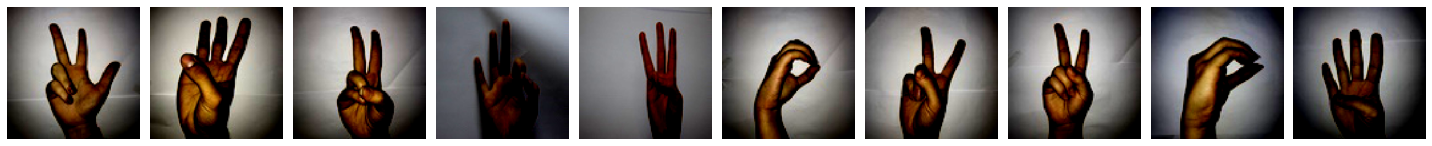

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [28]:
imgs, labels = next(train_batches) # Retrieve a batch of 10 
plotImage(imgs)
print(labels)

In [33]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [34]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [35]:
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x) #Functional Model

In [36]:
# Taking only the original input layer and the layer[:-6]+Output
model = Model(inputs=mobile.input, outputs=output)

In [37]:
#Only train the last 23 layersa
for layer in model.layers[:-23]:
    layer.trainable = False

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
172/172 - 43s - loss: 0.0920 - accuracy: 0.9854 - val_loss: 0.0964 - val_accuracy: 0.9833
Epoch 2/10
172/172 - 42s - loss: 0.0496 - accuracy: 0.9959 - val_loss: 0.0812 - val_accuracy: 0.9700
Epoch 3/10
172/172 - 43s - loss: 0.0334 - accuracy: 0.9959 - val_loss: 0.0432 - val_accuracy: 0.9900
Epoch 4/10
172/172 - 45s - loss: 0.0261 - accuracy: 0.9971 - val_loss: 0.0481 - val_accuracy: 0.9833
Epoch 5/10
172/172 - 44s - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9900
Epoch 6/10
172/172 - 38s - loss: 0.0145 - accuracy: 0.9982 - val_loss: 0.0926 - val_accuracy: 0.9667
Epoch 7/10
172/172 - 37s - loss: 0.0161 - accuracy: 0.9977 - val_loss: 0.0324 - val_accuracy: 0.9867
Epoch 8/10
172/172 - 35s - loss: 0.0116 - accuracy: 0.9977 - val_loss: 0.1181 - val_accuracy: 0.9567
Epoch 9/10
172/172 - 35s - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.0360 - val_accuracy: 0.9900
Epoch 10/10
172/172 - 36s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0297 - val_accura

Predict Sign language digits

In [43]:
test_labels = test_batches.classes

In [44]:
pred = model.predict(x=test_batches, verbose=2)

5/5 - 1s


In [45]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(pred, axis=1))

In [46]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [54]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting 'normalize=True'
    """
    import itertools
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix without normalisation')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix without normalisation
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 1 0 0 0]
 [0 0 0 4 0 0 0 1 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 1 4 0]
 [0 0 0 0 0 0 0 0 0 5]]


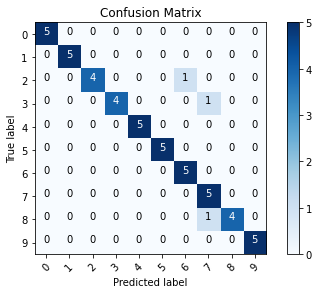

In [55]:
cm_plot_labels = list(range(10))
plot_confusion_matrix(cm, classes=cm_plot_labels, title='Confusion Matrix')